<img src="https://github.com/NOAA-OWP/gval/raw/main/docs/images/gval_light_mode.png" style="float:left">

# Multi-Class Categorical Comparisons

In [6]:
import rioxarray as rxr
import gval
import numpy as np
import pandas as pd
import xarray as xr
from itertools import product

pd.set_option('display.max_columns', None)

## Load Datasets

In [7]:
candidate = rxr.open_rasterio(
    "./candidate_map_multi_categorical.tif", mask_and_scale=True
)
benchmark = rxr.open_rasterio(
    "./benchmark_map_multi_categorical.tif", mask_and_scale=True
)
depth_raster = rxr.open_rasterio(
    "./candidate_raw_elevation_multi_categorical.tif", mask_and_scale=True
)

## Homogenize Datasets and Make Agreement Map

Although one can call `candidate.gval.categorical_compare` to run the entire workflow, in this case homogenization and creation of an agreement map will be done separately to show more options for multi-class comparisons.

#### Homogenize

In [8]:
candidate_r, benchmark_r = candidate.gval.homogenize(benchmark)
depth_raster_r, arb = depth_raster.gval.homogenize(benchmark_r)
del arb

#### Agreement Map

The following makes a pairing dictionary which maps combinations of values in the candidate and benchmark maps to unique values in the agreement map. In this case we will encode each value as concatenation of what the values are.  Instead of making a pairing dictionary one can use the `szudzik` or `cantor` pairing functions to make unique values for each combination of candidate and benchmark map values. e.g. <b>12</b> represents a class <b>1</b> for the candidate and a class <b>2</b> for the benchmark.

In [9]:
classes = [1, 2, 3, 4, 5]
pairing_dictionary = {(x, y): int(f'{x}{y}') for x, y in product(*([classes]*2))}

# Showing the first 6 entries
print('\n'.join([f'{k}: {v}' for k,v  in pairing_dictionary.items()][:6]))

(1, 1): 11
(1, 2): 12
(1, 3): 13
(1, 4): 14
(1, 5): 15
(2, 1): 21


The benchmark map has an extra class 0 which is very similar to nodata so it will not be included in `allow_benchmark_values` in the following methods.

In [10]:
agreement_map = candidate_r.gval.compute_agreement_map(
    benchmark_r,
    nodata=255,
    encode_nodata=True,
    comparison_function="pairing_dict",
    pairing_dict=pairing_dictionary,
    allow_candidate_values=classes,
    allow_benchmark_values=classes,
)

crosstab = candidate_r.gval.compute_crosstab(
    benchmark_r,
    comparison_function="pairing_dict",
    pairing_dict=pairing_dictionary,
    allow_candidate_values=classes,
    allow_benchmark_values=classes,
)

The following only shows a small subset of the map for memory purposes:

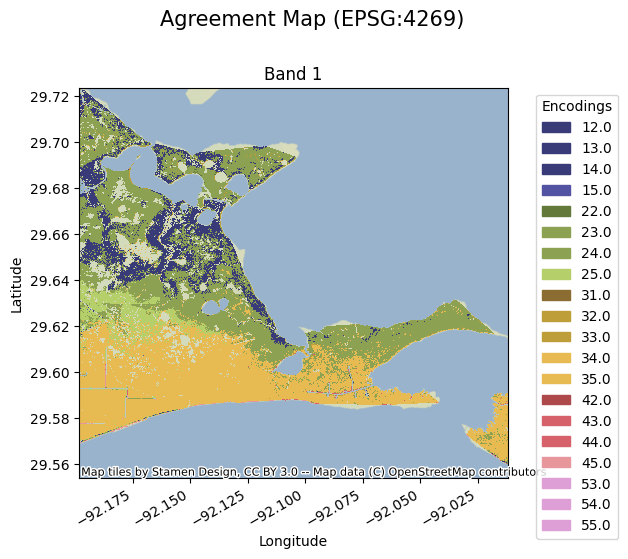

In [11]:
agreement_map.gval.cat_plot(
    title='Agreement Map', 
    figsize=(8, 6),
    colormap='tab20b'
)

## Comparisons

For multi-categorical statistics GVAL offers 4 methods of averaging:

1. No Averaging which provides one vs. all metrics on a class basis
1. Micro Averaging which sums up the contingencies of each class defined as either positive or negative
3. Macro Averaging which sums up the contingencies of one class vs all and then averages them
4. Weighted Averaging which does macro averaging with the inclusion of weights to be applied to each positive category.

### No Averaging

Using `None` for the averaging argument runs a one class vs. all methodology for each class and reports their metrics on a class basis:

In [12]:
no_averaged_metrics = crosstab.gval.compute_categorical_metrics(
    positive_categories=[1, 2, 3, 4, 5],
    negative_categories=None,
    average=None
)
no_averaged_metrics.transpose()

,0,1,2,3,4
band,1,1,1,1,1
positive_categories,1,2,3,4,5
fn,6.0,1043.0,318274.0,516572.0,364147.0
fp,172762.0,561004.0,462496.0,3775.0,5.0
tn,1043592.0,653360.0,422623.0,693617.0,852206.0
tp,0.0,953.0,12967.0,2396.0,2.0
accuracy,0.857963,0.537927,0.358109,0.57221,0.700622
balanced_accuracy,0.428984,0.507741,0.258311,0.499602,0.5
critical_success_index,0.0,0.001693,0.016337,0.004584,0.000005
equitable_threat_score,-0.000005,0.000055,-0.175401,-0.000455,-0.0


### Micro Averaging

The following is an example of a using micro averaging to combine classes to process two-class categorical statistics.  In this example we will use classes <b>1</b> and <b>2</b> as positive classes and classes <b>3</b>, <b>4</b>, and <b>5</b> as negative classes:

In [13]:
micro_averaged_metrics = crosstab.gval.compute_categorical_metrics(
    positive_categories=[1, 2],
    negative_categories=[3, 4, 5],
    average="micro"
)
micro_averaged_metrics.transpose()

,0
band,1
fn,382.0
fp,733099.0
tn,481259.0
tp,1620.0
accuracy,0.396987
balanced_accuracy,0.602749
critical_success_index,0.002204
equitable_threat_score,0.00056
f_score,0.004398


### Macro Averaging

The following shows macro averaging and is equivalent to the values of shared columns in `no_averaged_comps.mean()`:

In [14]:
macro_averaged_metrics = crosstab.gval.compute_categorical_metrics(
    positive_categories=classes,
    negative_categories=None,
    average="macro"
)
macro_averaged_metrics.transpose()

,0
band,1
accuracy,0.605366
balanced_accuracy,0.438927
critical_success_index,0.004524
equitable_threat_score,-0.035161
f_score,0.008933
false_discovery_rate,0.85941
false_negative_rate,0.895755
false_omission_rate,0.231481
false_positive_rate,0.22639


### Weighted Averaging

To further enhance `macro-averaging`, we can apply weights to the classes of interest in order to appropriately change the strength of evaluations for each class.  For instance, if we applied the following vector the classes uses in this notebook, `[1, 4, 1, 5, 1]`, classes <b>2</b> and <b>4</b> would have greater influence on the final averaging of the scores for all classes.  (All weight values are in reference to the other weight values respectively.  e.g. the vector `[5, 5, 5, 5, 5]` would cause no change in the averaging because each weight value is equivalent to a ll other weight values.)  Let's use the first weight vector mentioned in weighted averaging:

In [15]:
weight_averaged_metrics = crosstab.gval.compute_categorical_metrics(
    positive_categories=classes,
    weights=[1, 4, 1, 5, 1],
    negative_categories=None,
    average="weighted"
)
weight_averaged_metrics.transpose()

,0
band,1
accuracy,0.577454
balanced_accuracy,0.476356
critical_success_index,0.003836
equitable_threat_score,-0.014789
f_score,0.007609
false_discovery_rate,0.811574
false_negative_rate,0.835662
false_omission_rate,0.239133
false_positive_rate,0.211627


Regardless of the averaging methodology it seems as though the candidate does not agree with the benchmark.  We can now save the output.

## Save Output

In [16]:
# output agreement map
agreement_file = 'multi_categorical_agreement_map.tif'
metric_file = 'macro_averaged_metric_file.csv'

agreement_map.rio.to_raster(agreement_file)
macro_averaged_metrics.to_csv(metric_file)